In [1]:
print("hello world")

hello world


The following example will show a classification task (recognizing handwritten digits through the MNIST database) and will be based off of an example from Hands On Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron

<h3>Due to mldata.org and fetch_mldata being undreliable you will have to download the file mnist-original.mat from my github (link provided below) if you wish to run it yourself, however, if possible, just don't reload the kernel when you open this and you should see everything</h3>

In [2]:
# First things first we have to get the data, I have it saved locally but I will also push it up to git 
# and request it from my own github here

import requests

# A quick test with a text file to make sure everything's in order
url = "https://raw.githubusercontent.com/mdigreg2/DataScience/master/ml/datasets/test_text"
r = requests.get(url)
print(r)

<Response [200]>


In [3]:
print(help(r))

Help on Response in module requests.models object:

class Response(builtins.object)
 |  The :class:`Response <Response>` object, which contains a
 |  server's response to an HTTP request.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if the status code of the response is between
 |      400 and 600 to see if there was a client error or a server error. If
 |      the status code, is between 200 and 400, this will return True. This
 |      is **not** a check to see if the response code is ``200 OK``.
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Allows you to use a response as an iterator.
 |  
 |  __nonzero__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if

In [4]:
print(r.text)

test text



In [5]:
print(r.content)

b'test text\n'


So as it truns out, fetch_mldata no longer works, so just download the file from my github at https://github.com/mdigreg2/DataScience/blob/master/ml/datasets/mnist_original/mnist-original.mat and then run the program. It's a huge pain to pull it fropm github because it's over 50MB and git doesn't allow fro easy viewing of the raw file

In [6]:
from scipy.io import loadmat\
# Change this path to wherever you have downloaded this file 
mnist_path = "./datasets/mnist_original/mnist-original.mat"
mnist_raw = loadmat(mnist_path)
mnist = {
    "data":mnist_raw["data"].T,
    "target":mnist_raw["label"][0],
    "COL_NAMES":["label", "data"],
    "DESCR":"remake of mldata.org's mnist-original.mat"
}
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

There are 70,000 images of digits, the images are saved in a 28x28 grid

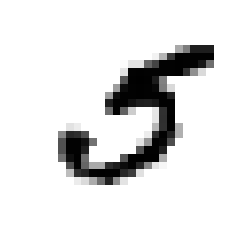

In [8]:
import matplotlib
import matplotlib.pyplot as pt
%matplotlib inline
a_digit = X[36000]
a_digit_image = a_digit.reshape(28,28)
pt.imshow(a_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
pt.axis("off")
pt.show()


In [13]:
y[36000]

5.0

In [14]:
import numpy as np
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Simplify the problem and make it binary. 5 or not a 5

In [15]:
y_train_5 = (y_train == 5)   #true for 5's   false for other digits
y_test_5 = (y_test == 5)

In [17]:
from sklearn.linear_model import SGDClassifier    #Stochastic Gradient Descent, good for large datasets

sgd_clf = SGDClassifier(random_state=42)    # because 42 is the answer to life
sgd_clf.fit(X_train, y_train_5)             #use our randomized data from all numbers and train it with the 5 and not 5 labels




SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
sgd_clf.predict([a_digit])       #It predicted if the digit from before was a 5!!

array([ True])

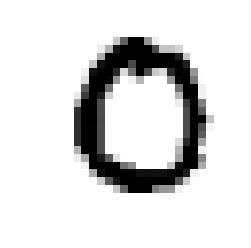

In [23]:
import matplotlib
import matplotlib.pyplot as pt
%matplotlib inline

a_digit_2 = X[3600]
a_digit_2_image = a_digit_2.reshape(28,28)
pt.imshow(a_digit_2_image, cmap=matplotlib.cm.binary, interpolation='nearest')
pt.axis("off")
pt.show()

In [21]:
sgd_clf.predict([X[3600]])       #it predicted that a 0 was, in fact, not a 5

array([False])

Cross Validation to test this thing's performance. The following code is sklearn's cross_val_score() but a little bit more

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)


# Step through every number in the dataset and test the classification of the clones sgd_classifier
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
    

0.9653
0.9668
0.9646


In [27]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9653, 0.9668, 0.9646])

Now hold on a second, is 96% that great when like ~90% of the numbers are indeed not 5    lets find out how mny numbers are not 5 by making something that returns '0' for the question "is it a five?"

In [30]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [31]:
never_5_classifier = Never5Classifier()

cross_val_score(never_5_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9128 , 0.9083 , 0.90785])

Lesson learned, ~90-91% of the dataset is not a 5 and accuracy isn't the best measure for heavily skewed datasets

Confusion matricies are much better for this kind of data. ex. if you wanted to see how many 5's were classified as 2's, you would check row 5 column 2

cross_val_predict() gives you a k-fold validation and tells you which every prediction made on the test fold



In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Each row in the matrix is an actual class, every column is a predicted class

the first row of this one considers non-5 images (negative class)
the first column considers the non-5 predictions (negative prediction)


|   true negative   |   false positive |
--------------------------------------------------
|   false negative  |   true positive   |
--------------------------------------------------


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53586,   993],
       [ 1073,  4348]])

In [39]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)    #4348 / (4348+993)


0.8140797603445048

In [41]:
recall_score(y_train_5, y_train_pred)      #4348 / (4348 + 1073)

0.8020660394761114

Precision = True Positives / (predicted positive)   i.e how often something marked as a positive is positive

recall = true positives / (actual number of positives)    i.e what percentage of positives are identified correctly


There is a combo called the F1 score which is the harmonic mean of Precision and Recall. This is heavily weighted by low values so you can only have a high F1 score if you have a high score in both recall and precision

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8080282475376325

In [43]:
y_scores = sgd_clf.decision_function([a_digit])
y_scores

array([2948.1351882])

In [44]:
threshold = 0
y_a_digit_pred = (y_scores > threshold)

In [45]:
y_a_digit_pred

array([ True])

In [46]:
threshold = 4000
y_a_digit_pred = (y_scores > threshold)

In [47]:
y_a_digit_pred

array([False])

seen above, you can set the threshold that the sgd classifier uses to amke the final desicion as to whether or not to classify something as positive or not

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

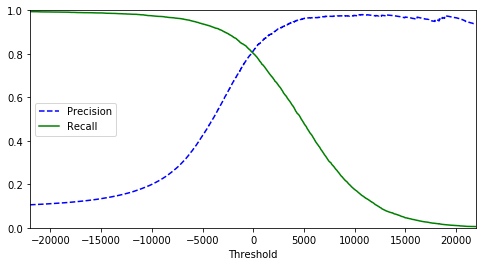

In [56]:
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    pt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    pt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    pt.xlabel("Threshold")
    pt.legend(loc="center left")
    pt.ylim([0,1])

pt.figure(figsize=(8,4))
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
pt.xlim([-22000, 22000])
pt.show()